In [49]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from typing import Optional

from src.batch_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

%load_ext autoreload
%autoreload 2

Using device: cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
def plot_simulation(
    net: Optional[PINN],
    full_df: pd.DataFrame,
    t: Optional[list] = None,
    y: Optional[list] = None,
    train_df: Optional[pd.DataFrame] = None,
    net_df: Optional[pd.DataFrame] = None,
    loss: Optional[float] = None,
):
    plt.figure(figsize=(10, 5))
    plt.scatter(
        full_df["RTime"],
        full_df["Glucose"],
        label="Glucose (All)",
        color="red",
        alpha=0.2,
    )
    plt.scatter(
        full_df["RTime"],
        full_df["Biomass"],
        label="Biomass (All)",
        color="green",
        alpha=0.2,
    )
    if t is not None:
        plt.plot(t, y[0], label="Biomass (ODE)", alpha=0.3)
        plt.plot(t, y[1], label="Glucose (ODE)", alpha=0.3)
    if train_df is not None:
        plt.scatter(
            train_df["RTime"],
            train_df["Glucose"],
            label="_Glucose (Train)",
            color="red",
            alpha=1,
        )
        plt.scatter(
            train_df["RTime"],
            train_df["Biomass"],
            label="_Biomass (Train)",
            color="green",
            alpha=1,
        )
    if net_df is not None:
        plt.scatter(
            net_df["RTime"],
            net_df["Glucose"],
            marker="+",
            label="Glucose (Predicted)",
            color="red",
            s=100,
            alpha=0.5,
        )
        plt.scatter(
            net_df["RTime"],
            net_df["Biomass"],
            marker="+",
            label="Biomass (Predicted)",
            color="green",
            s=100,
            alpha=0.5,
        )

    if net is not None:
        title = f"mu_max = {net.mu_max.item():.4f}, Ks = {net.K_s.item():.4f}, Yxs = {net.Y_xs.item():.4f} || Loss = {loss:.4f}"
        plt.title(title)
    plt.legend()
    plt.show()


def simulate(df, mu_max, Ks, Yxs):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs

    def system_ode(t, y):
        X, S = y
        mu = mu_max * S / (Ks + S)
        dXdt = mu * X
        dSdt = -mu * X / Yxs
        return [dXdt, dSdt]

    t_eval = np.linspace(df["RTime"].min(), df["RTime"].max(), 10000)
    sol = solve_ivp(
        system_ode,
        [df["RTime"].min(), df["RTime"].max()],
        [df["Biomass"].iloc[0], df["Glucose"].iloc[0]],
        t_eval=t_eval,
    )
    return sol

__Parameter estimation using PINN__

In [51]:
FILENAME = "../data/data_processed.xlsx"
EXPERIMENT = "BR01"

data = get_data(file_name=FILENAME)

df = data.loc[EXPERIMENT]

# Keep only the Batch phase
df = df[df["Process"] == "B"]
print(f"Dataset shape: {df.shape}")

Dataset shape: (8, 8)


In [52]:
# Fix 3rd data point
df["Glucose"].iloc[2] = df["Glucose"].iloc[1] - 0.2

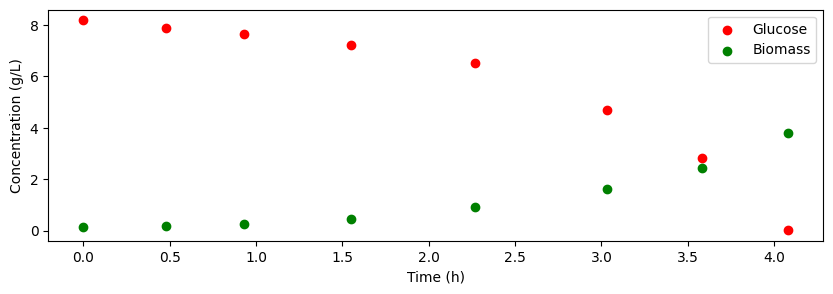

In [53]:
plt.figure(figsize=(10, 3))
plt.scatter(df["RTime"], df["Glucose"], label="Glucose", color="red")
plt.scatter(df["RTime"], df["Biomass"], label="Biomass", color="green")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.show()

In [54]:
# # Fit a polynomial to the data
# poly = PolynomialFeatures(degree=2)
# X = poly.fit_transform(df['RTime'].values.reshape(-1, 1))
# poly_reg = LinearRegression().fit(X, df[['Biomass', 'Glucose']])
# poly_df = pd.DataFrame({'RTime': df['RTime'], 'Biomass': poly_reg.predict(X)[:, 0], 'Glucose': poly_reg.predict(X)[:, 1]})

# plot_simulation(net=None, full_df=df, net_df=poly_df)


In [55]:
# def plot_linear_model(train_df: pd.DataFrame, full_df: pd.DataFrame, pred_df: pd.DataFrame):
#     plt.figure(figsize=(10, 3))
#     plt.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (All)', color='red', alpha=0.2)
#     plt.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (All)', color='green', alpha=0.2)
#     plt.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)
#     plt.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
#     plt.plot(pred_df['RTime'], pred_df['Glucose'], label='Glucose (Predicted)', color='red', alpha=0.5)
#     plt.plot(pred_df['RTime'], pred_df['Biomass'], label='Biomass (Predicted)', color='green', alpha=0.5)
#     plt.legend(fontsize=5, markerscale=0.5)
#     plt.xlabel('Time (h)')
#     plt.ylabel('Concentration (g/L)')
#     plt.title(f'Trained with {len(train_df)} data points')
#     plt.show()

# def fit_poly(train_df: pd.DataFrame, full_df: pd.DataFrame, degree: int = 3):
#     poly = PolynomialFeatures(degree=degree)
#     X = poly.fit_transform(train_df['RTime'].values.reshape(-1, 1))
#     poly_reg = LinearRegression().fit(X, train_df[['Biomass', 'Glucose']])
#     poly_df = pd.DataFrame({'RTime': full_df['RTime'], 'Biomass': poly_reg.predict(poly.fit_transform(full_df['RTime'].values.reshape(-1, 1)))[:, 0], \
#         'Glucose': poly_reg.predict(poly.fit_transform(full_df['RTime'].values.reshape(-1, 1)))[:, 1]})
#     return poly_df


# def fit_linear(train_df: pd.DataFrame, full_df: pd.DataFrame):
#     # Linear model
#     lin_reg = LinearRegression().fit(train_df[['RTime']], train_df[['Biomass', 'Glucose']])
#     lin_df = pd.DataFrame({'RTime': full_df['RTime'], 'Biomass': lin_reg.predict(full_df[['RTime']])[:, 0], 'Glucose': lin_reg.predict(full_df[['RTime']])[:, 1]})
#     return lin_df

# for i in range(2, len(df)+1):
#     train_df = df.iloc[:i]
#     # pred_df = fit_linear(train_df, df)
#     pred_df = fit_poly(train_df, df, degree=3)
#     plot_linear_model(train_df, df, pred_df)

Training using 2 data points
Epoch 0 || Total Loss: 66.8788, Loss Data: 32.8080, Loss IC: 34.0701, Loss ODE: 0.0006
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 500 || Total Loss: 0.0173, Loss Data: 0.0076, Loss IC: 0.0015, Loss ODE: 0.0082
mu_max: 0.4818, K_s: 0.5123, Y_xs: 0.5016
Epoch 1000 || Total Loss: 0.0149, Loss Data: 0.0065, Loss IC: 0.0012, Loss ODE: 0.0072
mu_max: 0.4603, K_s: 0.5250, Y_xs: 0.4772
Epoch 1500 || Total Loss: 0.0105, Loss Data: 0.0059, Loss IC: 0.0012, Loss ODE: 0.0034
mu_max: 0.4489, K_s: 0.5339, Y_xs: 0.4410
Epoch 2000 || Total Loss: 0.0086, Loss Data: 0.0050, Loss IC: 0.0011, Loss ODE: 0.0026
mu_max: 0.4642, K_s: 0.5299, Y_xs: 0.3916
Epoch 2500 || Total Loss: 0.0087, Loss Data: 0.0039, Loss IC: 0.0009, Loss ODE: 0.0040
mu_max: 0.4898, K_s: 0.5224, Y_xs: 0.3332
Epoch 3000 || Total Loss: 0.0077, Loss Data: 0.0026, Loss IC: 0.0006, Loss ODE: 0.0044
mu_max: 0.5163, K_s: 0.5190, Y_xs: 0.2744
Epoch 3500 || Total Loss: 0.0046, Loss Data: 0.0017, Loss IC: 0.0004,

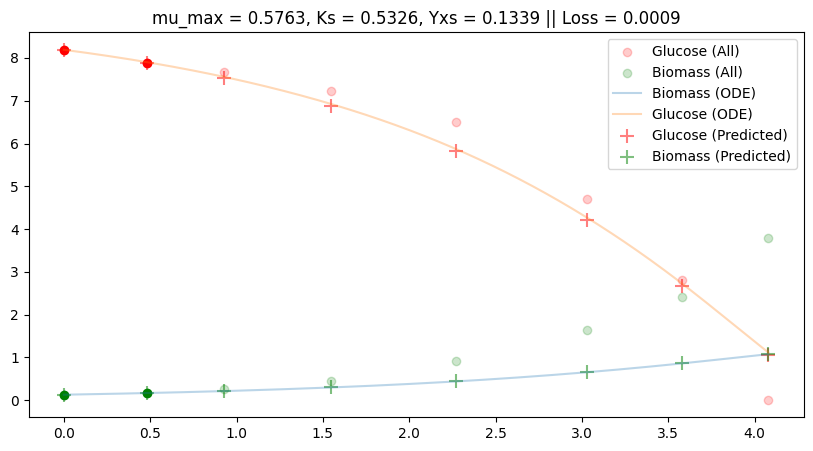

Training using 3 data points
Epoch 0 || Total Loss: 63.2664, Loss Data: 30.4898, Loss IC: 32.7751, Loss ODE: 0.0016
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 500 || Total Loss: 0.0193, Loss Data: 0.0073, Loss IC: 0.0023, Loss ODE: 0.0096
mu_max: 0.4736, K_s: 0.5101, Y_xs: 0.4654
Epoch 1000 || Total Loss: 0.0155, Loss Data: 0.0058, Loss IC: 0.0021, Loss ODE: 0.0076
mu_max: 0.4643, K_s: 0.5181, Y_xs: 0.4119
Epoch 1500 || Total Loss: 0.0134, Loss Data: 0.0043, Loss IC: 0.0017, Loss ODE: 0.0075
mu_max: 0.4984, K_s: 0.5173, Y_xs: 0.3540
Epoch 2000 || Total Loss: 0.0083, Loss Data: 0.0029, Loss IC: 0.0012, Loss ODE: 0.0043
mu_max: 0.5299, K_s: 0.5269, Y_xs: 0.2957
Epoch 2500 || Total Loss: 0.0054, Loss Data: 0.0018, Loss IC: 0.0008, Loss ODE: 0.0027
mu_max: 0.5455, K_s: 0.5499, Y_xs: 0.2471
Epoch 3000 || Total Loss: 0.0032, Loss Data: 0.0012, Loss IC: 0.0005, Loss ODE: 0.0015
mu_max: 0.5577, K_s: 0.5579, Y_xs: 0.2207
Epoch 3500 || Total Loss: 0.0022, Loss Data: 0.0011, Loss IC: 0.0004,

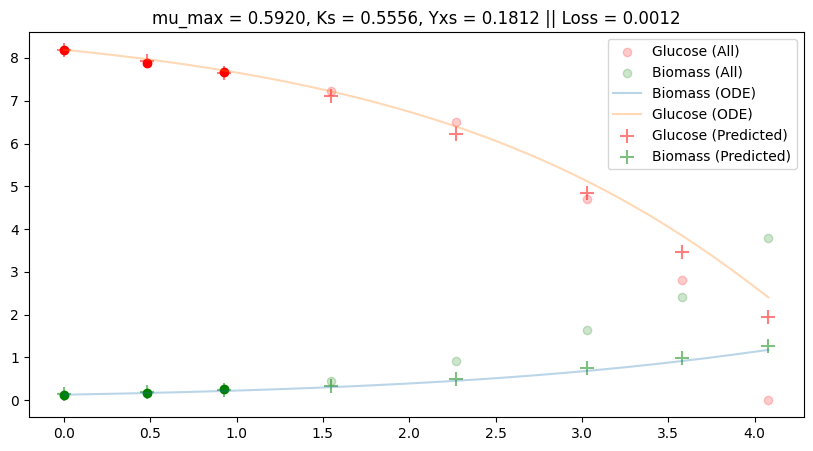

Training using 4 data points
Epoch 0 || Total Loss: 63.9515, Loss Data: 30.1869, Loss IC: 33.7643, Loss ODE: 0.0004
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 500 || Total Loss: 0.0311, Loss Data: 0.0105, Loss IC: 0.0035, Loss ODE: 0.0171
mu_max: 0.4897, K_s: 0.5096, Y_xs: 0.4734
Epoch 1000 || Total Loss: 0.0221, Loss Data: 0.0076, Loss IC: 0.0030, Loss ODE: 0.0114
mu_max: 0.5011, K_s: 0.5162, Y_xs: 0.4253
Epoch 1500 || Total Loss: 0.0149, Loss Data: 0.0047, Loss IC: 0.0021, Loss ODE: 0.0082
mu_max: 0.5404, K_s: 0.5139, Y_xs: 0.3770
Epoch 2000 || Total Loss: 0.0114, Loss Data: 0.0033, Loss IC: 0.0016, Loss ODE: 0.0065
mu_max: 0.5722, K_s: 0.5274, Y_xs: 0.3314
Epoch 2500 || Total Loss: 0.0058, Loss Data: 0.0019, Loss IC: 0.0008, Loss ODE: 0.0031
mu_max: 0.6008, K_s: 0.5558, Y_xs: 0.2904
Epoch 3000 || Total Loss: 0.0034, Loss Data: 0.0015, Loss IC: 0.0006, Loss ODE: 0.0014
mu_max: 0.6250, K_s: 0.5726, Y_xs: 0.2638
Epoch 3500 || Total Loss: 0.0023, Loss Data: 0.0014, Loss IC: 0.0003,

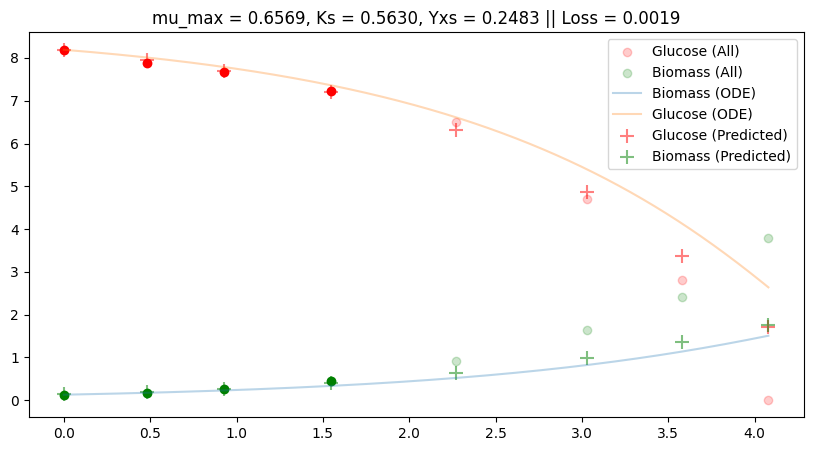

Training using 5 data points
Epoch 0 || Total Loss: 60.4711, Loss Data: 27.6708, Loss IC: 32.7984, Loss ODE: 0.0019
mu_max: 0.5001, K_s: 0.4999, Y_xs: 0.4999
Epoch 500 || Total Loss: 0.0457, Loss Data: 0.0167, Loss IC: 0.0051, Loss ODE: 0.0239
mu_max: 0.4890, K_s: 0.5179, Y_xs: 0.4785
Epoch 1000 || Total Loss: 0.0261, Loss Data: 0.0102, Loss IC: 0.0034, Loss ODE: 0.0125
mu_max: 0.5277, K_s: 0.5026, Y_xs: 0.4316
Epoch 1500 || Total Loss: 0.0142, Loss Data: 0.0061, Loss IC: 0.0022, Loss ODE: 0.0058
mu_max: 0.5706, K_s: 0.4701, Y_xs: 0.3914
Epoch 2000 || Total Loss: 0.0092, Loss Data: 0.0045, Loss IC: 0.0012, Loss ODE: 0.0034
mu_max: 0.6018, K_s: 0.4461, Y_xs: 0.3621
Epoch 2500 || Total Loss: 0.0072, Loss Data: 0.0043, Loss IC: 0.0010, Loss ODE: 0.0018
mu_max: 0.6246, K_s: 0.4297, Y_xs: 0.3450
Epoch 3000 || Total Loss: 0.0064, Loss Data: 0.0042, Loss IC: 0.0007, Loss ODE: 0.0016
mu_max: 0.6423, K_s: 0.4164, Y_xs: 0.3387
Epoch 3500 || Total Loss: 0.0062, Loss Data: 0.0042, Loss IC: 0.0006,

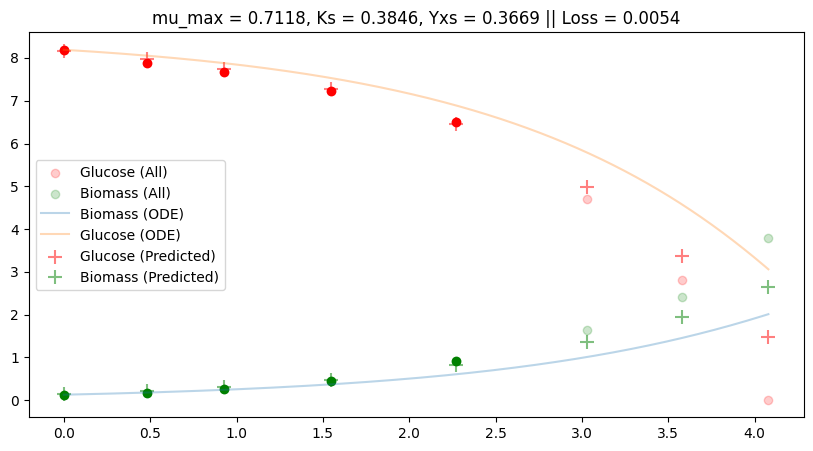

Training using 6 data points
Epoch 0 || Total Loss: 61.1358, Loss Data: 26.6156, Loss IC: 34.5179, Loss ODE: 0.0023
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 500 || Total Loss: 0.1054, Loss Data: 0.0421, Loss IC: 0.0054, Loss ODE: 0.0579
mu_max: 0.5079, K_s: 0.5334, Y_xs: 0.4547
Epoch 1000 || Total Loss: 0.0359, Loss Data: 0.0205, Loss IC: 0.0026, Loss ODE: 0.0128
mu_max: 0.5729, K_s: 0.5508, Y_xs: 0.4026
Epoch 1500 || Total Loss: 0.0160, Loss Data: 0.0094, Loss IC: 0.0012, Loss ODE: 0.0054
mu_max: 0.6270, K_s: 0.4948, Y_xs: 0.3700
Epoch 2000 || Total Loss: 0.0113, Loss Data: 0.0066, Loss IC: 0.0007, Loss ODE: 0.0040
mu_max: 0.6583, K_s: 0.4539, Y_xs: 0.3560
Epoch 2500 || Total Loss: 0.0096, Loss Data: 0.0058, Loss IC: 0.0006, Loss ODE: 0.0032
mu_max: 0.6794, K_s: 0.4254, Y_xs: 0.3556
Epoch 3000 || Total Loss: 0.0091, Loss Data: 0.0054, Loss IC: 0.0004, Loss ODE: 0.0032
mu_max: 0.6965, K_s: 0.4035, Y_xs: 0.3625
Epoch 3500 || Total Loss: 0.0079, Loss Data: 0.0050, Loss IC: 0.0006,

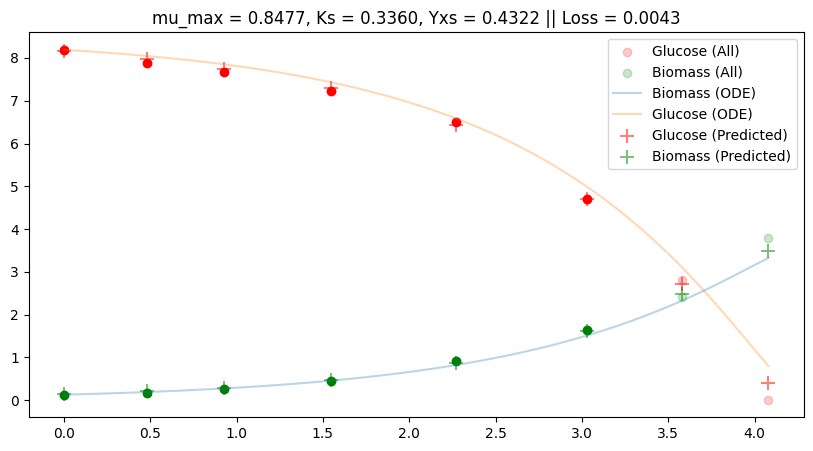

Training using 7 data points
Epoch 0 || Total Loss: 55.8605, Loss Data: 22.7442, Loss IC: 33.1159, Loss ODE: 0.0004
mu_max: 0.5001, K_s: 0.4999, Y_xs: 0.4999
Epoch 500 || Total Loss: 0.1702, Loss Data: 0.0741, Loss IC: 0.0068, Loss ODE: 0.0893
mu_max: 0.5165, K_s: 0.5083, Y_xs: 0.4669
Epoch 1000 || Total Loss: 0.0627, Loss Data: 0.0391, Loss IC: 0.0033, Loss ODE: 0.0202
mu_max: 0.5687, K_s: 0.4741, Y_xs: 0.4227
Epoch 1500 || Total Loss: 0.0309, Loss Data: 0.0185, Loss IC: 0.0019, Loss ODE: 0.0105
mu_max: 0.6075, K_s: 0.4328, Y_xs: 0.3893
Epoch 2000 || Total Loss: 0.0181, Loss Data: 0.0097, Loss IC: 0.0010, Loss ODE: 0.0075
mu_max: 0.6344, K_s: 0.4008, Y_xs: 0.3690
Epoch 2500 || Total Loss: 0.0138, Loss Data: 0.0071, Loss IC: 0.0007, Loss ODE: 0.0060
mu_max: 0.6544, K_s: 0.3751, Y_xs: 0.3611
Epoch 3000 || Total Loss: 0.0114, Loss Data: 0.0061, Loss IC: 0.0006, Loss ODE: 0.0047
mu_max: 0.6711, K_s: 0.3524, Y_xs: 0.3625
Epoch 3500 || Total Loss: 0.0100, Loss Data: 0.0054, Loss IC: 0.0005,

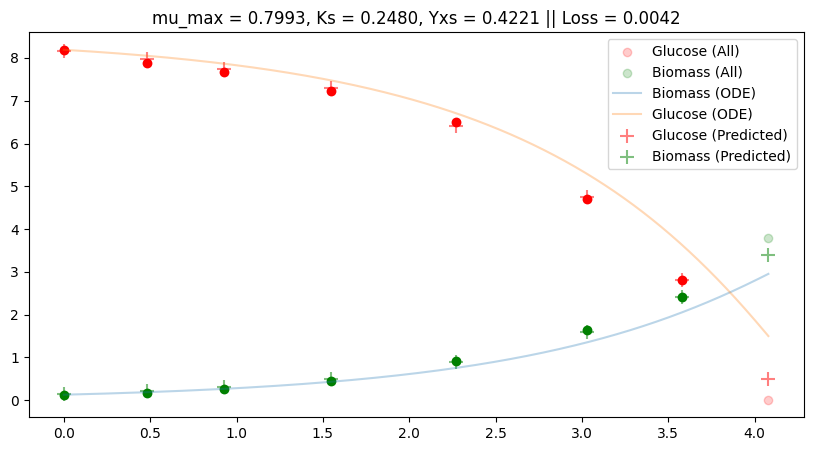

Training using 8 data points
Epoch 0 || Total Loss: 52.4340, Loss Data: 20.2246, Loss IC: 32.2089, Loss ODE: 0.0005
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 500 || Total Loss: 0.2422, Loss Data: 0.1837, Loss IC: 0.0047, Loss ODE: 0.0538
mu_max: 0.5396, K_s: 0.4693, Y_xs: 0.4583
Epoch 1000 || Total Loss: 0.1261, Loss Data: 0.0963, Loss IC: 0.0022, Loss ODE: 0.0275
mu_max: 0.5868, K_s: 0.4066, Y_xs: 0.4139
Epoch 1500 || Total Loss: 0.0779, Loss Data: 0.0567, Loss IC: 0.0012, Loss ODE: 0.0200
mu_max: 0.6196, K_s: 0.3575, Y_xs: 0.3857
Epoch 2000 || Total Loss: 0.0573, Loss Data: 0.0396, Loss IC: 0.0009, Loss ODE: 0.0169
mu_max: 0.6440, K_s: 0.3152, Y_xs: 0.3727
Epoch 2500 || Total Loss: 0.0445, Loss Data: 0.0301, Loss IC: 0.0006, Loss ODE: 0.0138
mu_max: 0.6647, K_s: 0.2769, Y_xs: 0.3720
Epoch 3000 || Total Loss: 0.0342, Loss Data: 0.0239, Loss IC: 0.0006, Loss ODE: 0.0097
mu_max: 0.6851, K_s: 0.2395, Y_xs: 0.3781
Epoch 3500 || Total Loss: 0.0266, Loss Data: 0.0186, Loss IC: 0.0004,

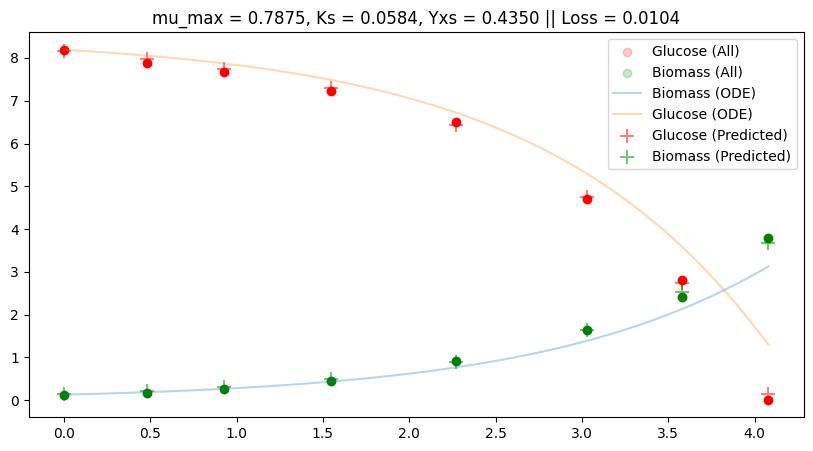

In [56]:
for i in range(2, len(df)+1):
    print(f'Training using {i} data points')
    
    _df = df.iloc[:i]
    t_start, t_end = _df['RTime'].min(), _df['RTime'].max()
    
    t = numpy_to_tensor(_df['RTime'].values)
    X = numpy_to_tensor(_df['Biomass'].values)
    S = numpy_to_tensor(_df['Glucose'].values)
    X_S = torch.cat((X, S), 1)
    
    # Define and Train PINN 
    net = PINN(1, 2).to(device) 
    
    net, total_loss = train(net, t, X_S, df, num_epochs=50000, verbose=True)

    # Store the results
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df['RTime'].values
    net_df['RTime'] = t_test
    t_test = numpy_to_tensor(t_test)
    net_df['Biomass'] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df['Glucose'] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    
    mu_max = net.mu_max.item()
    Ks = net.K_s.item()
    Yxs = net.Y_xs.item()
    
    print(f'mu_max: {mu_max:4f}, Ks: {Ks:4f}, Yxs: {Yxs:.4f}')
    
    solution = simulate(df, mu_max, Ks, Yxs)
    # Replace negative values with 0
    solution.y[solution.y < 0] = 0
    
    plot_simulation(net, df, solution.t, solution.y, _df, net_df=net_df, loss=total_loss)